# 0. Import Packages and Define functions

In [1]:
# import the required packages
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# outlier handling
from feature_engine.outliers import Winsorizer

# numerical transformation
from feature_engine.transformation import YeoJohnsonTransformer

# the scaler 
from sklearn.preprocessing import MinMaxScaler

# train test split
from sklearn.model_selection import train_test_split

# regression
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# improving log/lin reg
import statsmodels.api as sm

# voting classifier
from sklearn.ensemble import VotingClassifier, VotingRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# SVM
from sklearn.svm import SVC, SVR

# xg boost
from xgboost import XGBClassifier, XGBRegressor

# adaboost
from sklearn. ensemble import AdaBoostRegressor

# GridSearchCV
from sklearn.model_selection import GridSearchCV

# decision tree
from sklearn import tree

# random forest
from sklearn. ensemble import RandomForestClassifier, RandomForestRegressor

# cross validation for random forest reg
from sklearn.model_selection import cross_validate

# r^2
from sklearn.metrics import r2_score


# # remove in future warnings
# import warnings
# warnings.filterwarnings('ignore')

In [2]:
# function to create histogram, Q-Q plot and boxplot.

def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.suptitle(variable)

    plt.show()

In [3]:
# function to create monotonic line graphs

def diagnostic_plots_monotonic_relation(df_before, df_after, variable, target):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(12, 4))

    # before
    plt.subplot(1, 2, 1)
    df_before.groupby([variable])[target].mean().plot()
    plt.ylabel('Mean of target')

    # after
    plt.subplot(1, 2, 2)
    df_after.groupby([variable])[target].mean().plot()
    plt.ylabel('Mean of target')

    plt.suptitle('Relationship between {} and the target'.format(variable))

    plt.show()

# 1. HR Analytics

## 1.1 Load and Sample the data

### 1.1.1 Loading Data

In [4]:
# loading the hr_data from csv file
hr_df_main = pd.read_csv('hr_data.csv')
hr_df_main

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54803,3030,Technology,region_14,Bachelor's,m,sourcing,1,48,3.0,17,0,0,78,0
54804,74592,Operations,region_27,Master's & above,f,other,1,37,2.0,6,0,0,56,0
54805,13918,Analytics,region_1,Bachelor's,m,other,1,27,5.0,3,1,0,79,0
54806,13614,Sales & Marketing,region_9,NaN,m,sourcing,1,29,1.0,2,0,0,45,0


#### Drop Unnecessary Columns

In [5]:
hr_df_main.drop(columns='employee_id',inplace=True)

### 1.1.2 Handling Missing Values

Identify nulls

In [6]:
hr_df_main.isnull().sum()

department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

In [7]:
hr_df_main[hr_df_main['length_of_service']==1].isnull().sum()

department                 0
region                     0
education                428
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

All nulls from previous_year_rating are from employees who have 1 in length_of_service. Thus, to ensure the imputed values for the nulls are as close to a real number, the median and mode used for imputation will be based off the null row's department median/mode.

Get replacement map for null imputation

In [8]:
# creates a map of modal education and median previous_year_rating for a given department
hr_df_main_map = hr_df_main.groupby(['department']).agg({'education':pd.Series.mode,'previous_year_rating':['median']})
hr_df_main_map.reset_index(level=['department'],inplace=True)
hr_df_main_map.columns = hr_df_main_map.columns.droplevel(1)
hr_df_main_map = hr_df_main_map.values.tolist()
hr_df_main_map

[['Analytics', "Bachelor's", 3.0],
 ['Finance', "Bachelor's", 3.0],
 ['HR', "Bachelor's", 3.0],
 ['Legal', "Bachelor's", 3.0],
 ['Operations', "Bachelor's", 4.0],
 ['Procurement', "Bachelor's", 3.0],
 ['R&D', "Bachelor's", 3.0],
 ['Sales & Marketing', "Bachelor's", 3.0],
 ['Technology', "Bachelor's", 3.0]]

Apply map to remove nulls

In [9]:
# uses map from above to replace missing values

# create an empty df that will contain rows of only the imputed rows
hr_df_nulls = hr_df_main.copy()
hr_df_nulls.drop(hr_df_nulls.index, inplace=True)

for dept in hr_df_main_map:
    
    hr_df_temp = hr_df_main[(hr_df_main.where(hr_df_main['department']==dept[0])['department']).notnull()]\
                            .fillna({'education':dept[1],'previous_year_rating':dept[2]})
    
    hr_df_nulls = pd.concat([hr_df_nulls,hr_df_temp])

# update main dataframe with imputed values
hr_df_main.update(hr_df_nulls)
hr_df_main

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54803,Technology,region_14,Bachelor's,m,sourcing,1,48,3.0,17,0,0,78,0
54804,Operations,region_27,Master's & above,f,other,1,37,2.0,6,0,0,56,0
54805,Analytics,region_1,Bachelor's,m,other,1,27,5.0,3,1,0,79,0
54806,Sales & Marketing,region_9,Bachelor's,m,sourcing,1,29,1.0,2,0,0,45,0


Check for nulls

In [10]:
hr_df_main.isnull().sum()

department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
is_promoted             0
dtype: int64

### 1.1.3 Dealing with Outliers

Identify continuous variables

In [11]:
hr_df_main.dtypes

department               object
region                   object
education                object
gender                   object
recruitment_channel      object
no_of_trainings           int64
age                       int64
previous_year_rating    float64
length_of_service         int64
KPIs_met >80%             int64
awards_won?               int64
avg_training_score        int64
is_promoted               int64
dtype: object

Only age,length_of_service and avg_training_score will be considered for outlier handling</br>
no_of_trainings, previous_year_rating and all other int64 variables will be treated as categorical values

In [12]:
# get continuous variables
hr_df_outliers = hr_df_main[['age','length_of_service','avg_training_score']].copy()
hr_df_outliers

,age,length_of_service,avg_training_score
0,35,8,49
1,30,4,60
2,34,7,50
3,39,10,50
4,45,2,73
...,...,...,...
54803,48,17,78
54804,37,6,56
54805,27,3,79
54806,29,2,45


Visualise continuous variables

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


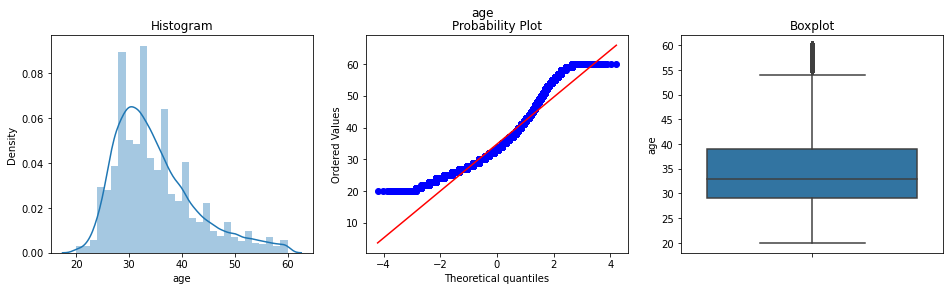

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


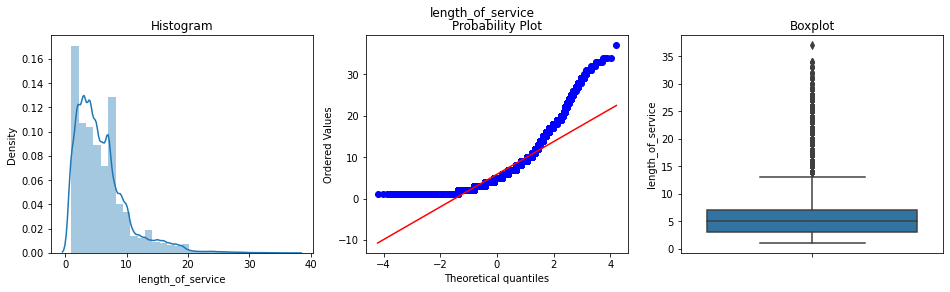

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


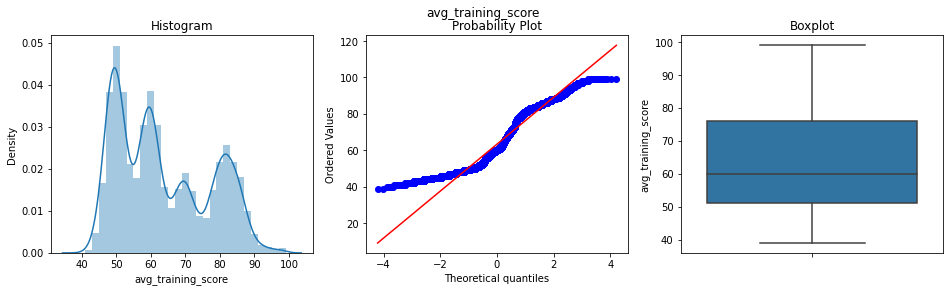

In [13]:
for cols in hr_df_outliers:
    diagnostic_plots(hr_df_outliers, cols)

Perform winsorization on outliers

In [14]:
# winsorize the outliers
windsorizer = Winsorizer(capping_method='iqr', 
                          tail='right', 
                          fold=3,
                          variables=['length_of_service'])

windsorizer.fit(hr_df_main)
hr_df_main = windsorizer.transform(hr_df_main)

Verify winsorization effect

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


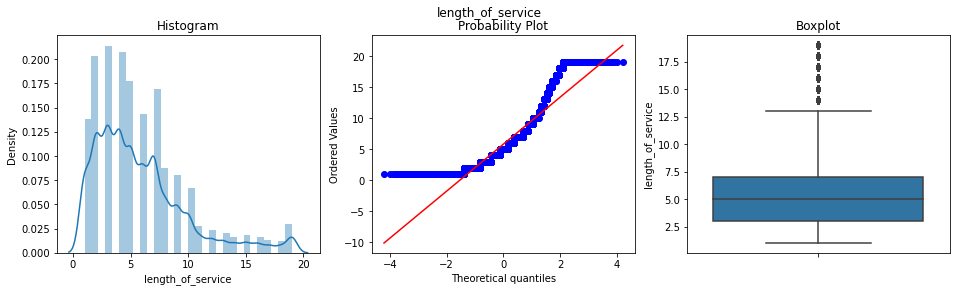

In [15]:
diagnostic_plots(hr_df_main, 'length_of_service')

### 1.1.4 Stratified Sampling

In [16]:
hr_df_true=hr_df_main[hr_df_main['is_promoted']==1]
hr_df_true.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
11,Sales & Marketing,region_7,Bachelor's,f,sourcing,1,35,5.0,3.0,1,0,50,1
39,Sales & Marketing,region_28,Bachelor's,m,sourcing,1,33,5.0,6.0,1,0,51,1
60,Sales & Marketing,region_4,Master's & above,m,other,1,50,4.0,17.0,1,0,47,1
66,Finance,region_22,Bachelor's,m,other,1,27,3.0,1.0,1,1,58,1
67,Sales & Marketing,region_22,Bachelor's,m,sourcing,1,27,3.0,1.0,0,0,61,1


In [17]:
len(hr_df_true)

4668

In [18]:
hr_df_false=hr_df_main[hr_df_main['is_promoted']==0]
hr_df_false.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8.0,1,0,49,0
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4.0,0,0,60,0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7.0,0,0,50,0
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10.0,0,0,50,0
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2.0,0,0,73,0


In [19]:
len(hr_df_false)

50140

In [20]:
hr_df_sampled = hr_df_false.sample(n=len(hr_df_true), random_state=30).copy()
hr_df_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4668 entries, 15424 to 22461
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   department            4668 non-null   object 
 1   region                4668 non-null   object 
 2   education             4668 non-null   object 
 3   gender                4668 non-null   object 
 4   recruitment_channel   4668 non-null   object 
 5   no_of_trainings       4668 non-null   int64  
 6   age                   4668 non-null   int64  
 7   previous_year_rating  4668 non-null   float64
 8   length_of_service     4668 non-null   float64
 9   KPIs_met >80%         4668 non-null   int64  
 10  awards_won?           4668 non-null   int64  
 11  avg_training_score    4668 non-null   int64  
 12  is_promoted           4668 non-null   int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 510.6+ KB


In [21]:
hr_df_main['is_promoted'].value_counts()

0    50140
1     4668
Name: is_promoted, dtype: int64

In [22]:
hr_df_stratified=pd.concat([hr_df_true,hr_df_sampled],axis=0)
hr_df_main = hr_df_stratified
hr_df_main['is_promoted'].value_counts()

1    4668
0    4668
Name: is_promoted, dtype: int64

In [23]:
hr_df_main['department'].value_counts()

Sales & Marketing    2628
Operations           1985
Technology           1342
Procurement          1313
Analytics             977
Finance               409
HR                    382
R&D                   159
Legal                 141
Name: department, dtype: int64

### 1.1.5 Categorical Encoding

Identify categorical variables

In [24]:
# get categorical variables that need encoding
hr_df_categorical = hr_df_main[['department','region','education','recruitment_channel','gender']].copy()
hr_df_categorical.nunique()

department              9
region                 34
education               3
recruitment_channel     3
gender                  2
dtype: int64

Perform ordinal encoding to remove strings

In [25]:
# ordinal encoding
# creates a map or integers ordered by the grouped mean relation to the target varaible 'is_promoted'
# this makes sure that as integer value increases, likelyhood of 'is_promoted' increases as well

# create a temporary dataframe to see change from encoding
hr_df_main_before = hr_df_main.copy()

for col in hr_df_categorical:
    # let's generate an ordered list with the labels of the columns
    ordered_labels = hr_df_main.groupby([col])['is_promoted'].mean().sort_values().index

    # next let's create a dictionary with the mappings of categories to numbers
    ordinal_mapping = {k: i for i, k in enumerate(ordered_labels, 0)}

    # replace the labels with the ordered numbers
    hr_df_main[col] = hr_df_main[col].map(ordinal_mapping)

Visualise change

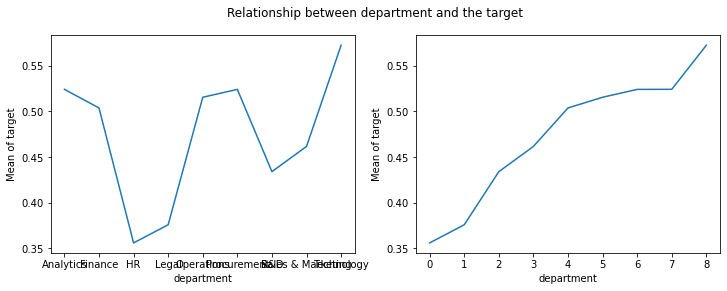

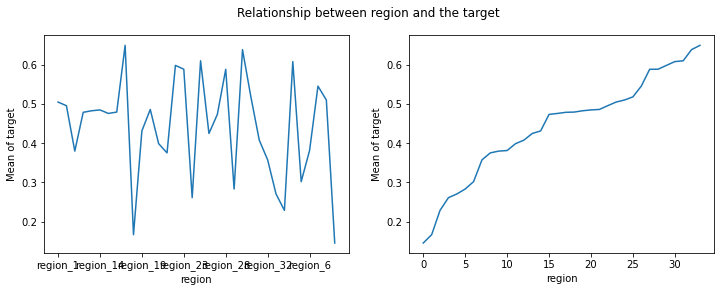

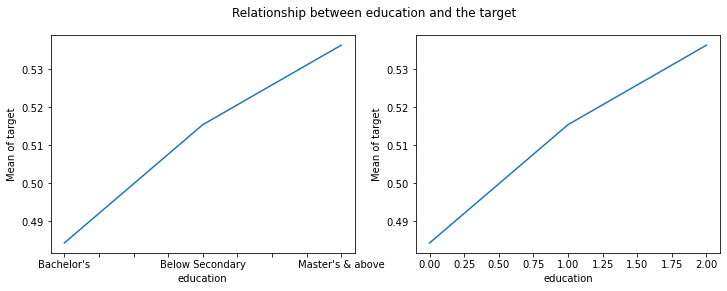

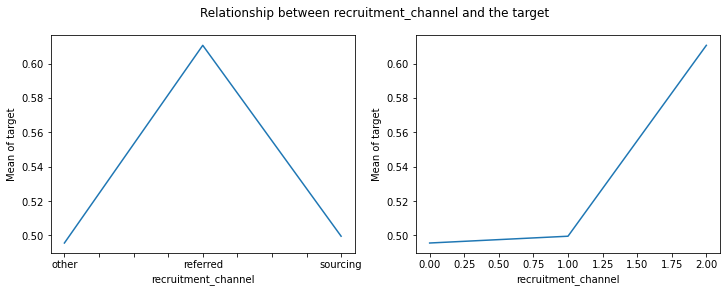

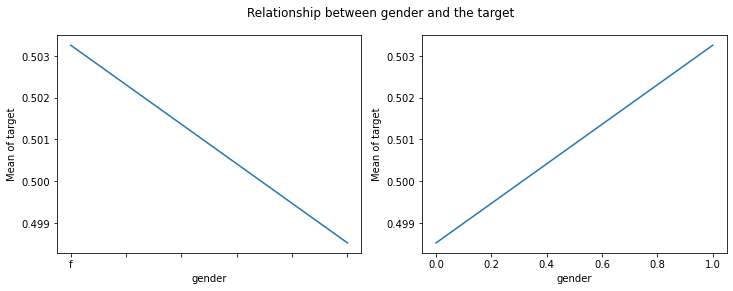

In [26]:
# let's find visualise the distributions
for col in hr_df_categorical:
    diagnostic_plots_monotonic_relation(hr_df_main_before, hr_df_main, col, 'is_promoted')

### 1.1.6 Numerical Transformation

In [27]:
# get continuous variables
hr_df_transform = hr_df_main[['age','length_of_service']].copy()
hr_df_transform

,age,length_of_service
11,35,3.0
39,33,6.0
60,50,17.0
66,27,1.0
67,27,1.0
...,...,...
40403,32,6.0
39304,48,14.0
22849,46,11.0
48620,33,6.0


c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


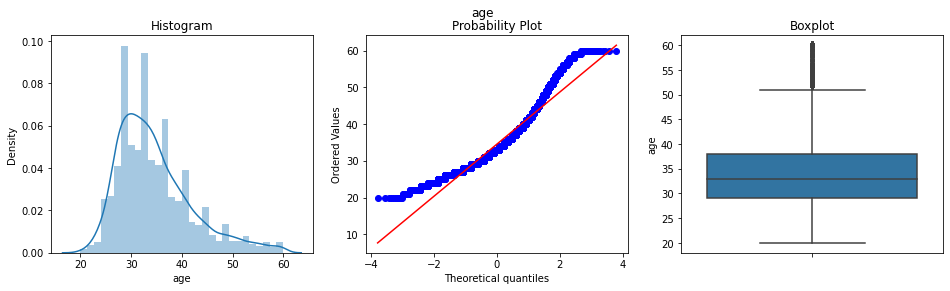

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


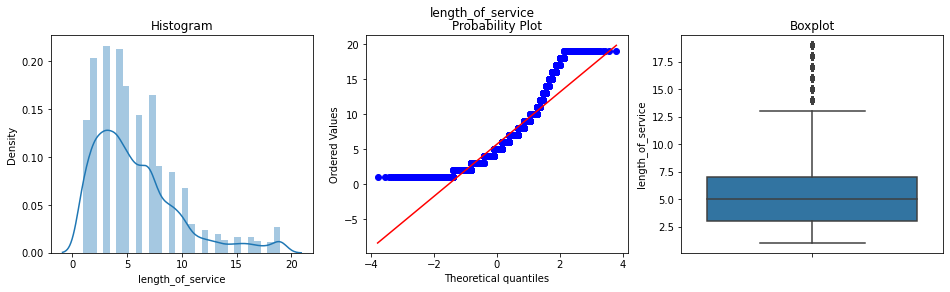

In [28]:
for cols in hr_df_transform:
    diagnostic_plots(hr_df_transform, cols)

In [29]:
hr_df_transform.columns.tolist()

['age', 'length_of_service']

In [30]:
# initialize the transformer
# YeoJohnson
ygt = YeoJohnsonTransformer(variables=hr_df_transform.columns.tolist())
# fit transformer to data set
ygt.fit(hr_df_main)
# transform variables within our data set
hr_df_main = ygt.transform(hr_df_main)

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


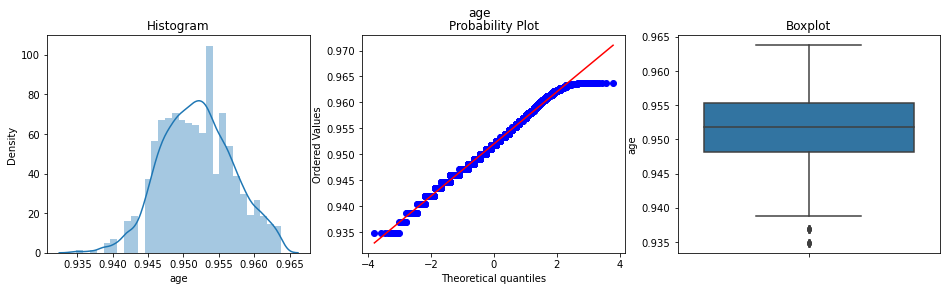

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


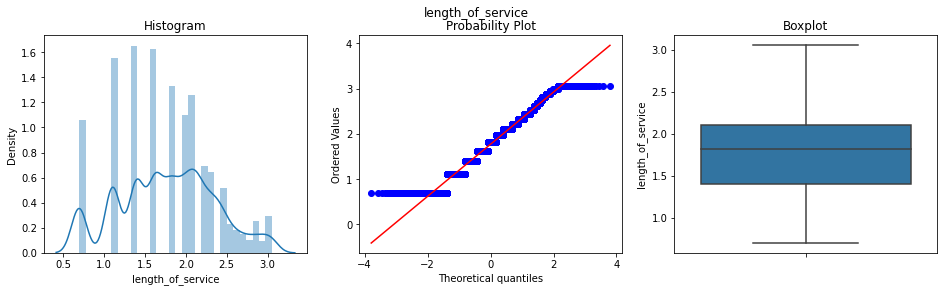

In [31]:
for cols in hr_df_transform:
    diagnostic_plots(hr_df_main, cols)

### 1.1.7 Scaling

In [32]:
# set up the  MinMax Scaler
scaler = MinMaxScaler()

# fit the scaler to the df_main, it will learn the parameters
scaler.fit(hr_df_main)

# transform df_main
hr_df_scaled = scaler.transform(hr_df_main)

# let's transform the returned NumPy arrays to dataframes
hr_df_main = pd.DataFrame(hr_df_scaled, columns=hr_df_main.columns)


## 1.2 Build the Model(s)

### 1.2.1 Train Test Split 

In [33]:
# train test split with dropping of target variable in X datasets
hr_X_train, hr_X_test, hr_y_train, hr_y_test = train_test_split(hr_df_main.drop('is_promoted', axis=1),
                                                    hr_df_main['is_promoted'], 
                                                    test_size=0.3, 
                                                    random_state=10)

hr_X_train.shape, hr_X_test.shape, hr_y_train.shape, hr_y_test.shape

((6535, 12), (2801, 12), (6535,), (2801,))

In [34]:
hr_X_train

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
6333,0.625,0.636364,0.0,0.0,0.0,0.000000,0.341281,0.50,0.000000,1.0,0.0,0.372881
2078,0.125,0.636364,0.0,0.0,0.0,0.000000,0.494734,0.75,0.394548,1.0,0.0,0.338983
720,0.375,0.636364,1.0,0.0,0.0,0.000000,0.726804,0.50,0.695983,0.0,0.0,0.372881
5753,0.625,0.878788,0.0,0.0,0.5,0.000000,0.383801,0.75,0.298054,1.0,0.0,0.355932
6870,0.875,0.151515,0.0,0.0,0.5,0.000000,0.423357,0.00,0.298054,0.0,0.0,0.661017
...,...,...,...,...,...,...,...,...,...,...,...,...
4829,1.000,0.636364,1.0,1.0,0.5,0.000000,0.921719,1.00,0.298054,1.0,0.0,0.694915
7291,0.375,0.575758,0.0,1.0,0.5,0.000000,0.638142,1.00,0.649998,0.0,0.0,0.203390
1344,0.625,0.636364,0.0,1.0,0.0,0.000000,0.557370,0.50,0.394548,1.0,0.0,0.305085
7293,0.375,0.636364,0.0,0.0,0.0,0.222222,0.527042,0.50,0.000000,0.0,0.0,0.152542


In [35]:
hr_y_train

6333    0.0
2078    1.0
720     1.0
5753    0.0
6870    0.0
       ... 
4829    0.0
7291    0.0
1344    1.0
7293    0.0
1289    1.0
Name: is_promoted, Length: 6535, dtype: float64

### 1.2.2 Logistic Reggresion (Base Model)

In [36]:
# Create the model for logistic regression
hr_logReg = LogisticRegression(solver='lbfgs', max_iter=10000) 

# Fit the model to the training set
hr_logReg.fit(hr_X_train,hr_y_train)

LogisticRegression(max_iter=10000)

### 1.2.3 XGBoostClassifier  (ensemble Learning) 

In [37]:
# Build XGBoost Model 
hr_XGB = XGBClassifier(use_label_encoder=False)
hr_XGB.fit(hr_X_train,hr_y_train)

[18:36:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

### 1.2.4 Support Vector Machine (Classifier) 

In [38]:
# Build SVM Model 
hr_SVC = SVC(kernel='linear', C=1)
hr_SVC.fit(hr_X_train,hr_y_train)

SVC(C=1, kernel='linear')

## 1.3 Evaluate and Improve the Model(s)

### 1.3.1 Logistic Reggression

#### Evaluation

In [39]:
# Calculated the fitted values for training set
hr_y_fitted = hr_logReg.predict(hr_X_train) # returns 0 or 1
hr_y_fitted_prob = hr_logReg.predict_proba(hr_X_train)[:,0] # returns probabilities

In [40]:
print(hr_y_fitted)
print(hr_y_fitted_prob)

[1. 1. 0. ... 0. 0. 1.]
[0.45591861 0.18757846 0.71408438 ... 0.54159133 0.91822407 0.05572201]


In [41]:
# calculated the training accuracy
print(hr_logReg.score(hr_X_train, hr_y_train), '(Train Accuracy)')
# calculated the testing accuracy
print(hr_logReg.score(hr_X_test, hr_y_test), '(Test Accuracy)')

0.7282325937260903 (Train Accuracy)
0.73545162441985 (Test Accuracy)


#### Improvement

In [42]:
# Create another model hr_logReg_improv using statsmodel.api: the Logit method and fit function
hr_logReg_improv = sm.Logit(hr_y_train, hr_X_train).fit()

Optimization terminated successfully.
         Current function value: 0.538034
         Iterations 7


In [43]:
# Print out the Model Summary
hr_logReg_improv.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            is_promoted   No. Observations:                 6535
Model:                          Logit   Df Residuals:                     6523
Method:                           MLE   Df Model:                           11
Date:                Sat, 11 Feb 2023   Pseudo R-squ.:                  0.2238
Time:                        18:36:27   Log-Likelihood:                -3516.0
converged:                       True   LL-Null:                       -4529.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
department              -3.1040      0.188    -16.488      0.000      -3.473      -2.735
region                  -0.0264      0.117     -0.226      0.821      -0.255       0.203
education                0.4119      0.069      5.933      0.000       0.276       0.548
gender                  -0.1139      0.063     -1.815      0.070      -0.237       0.009
recruitment_channel     -0.3239      0.105     -3.079      0.002      -0.530      -0.118
no_of_trainings         -2.2554      0.492     -4.580      0.000      -3.220      -1.290
age                     -2.9238      0.202    -14.500      0.000      -3.319      -2.529
previous_year_rating     0.6883      0.100      6.875      0.000       0.492       0.884
length_of_service        0.6731      0.157      4.281      0.000       0.365       0.981
KPIs_met >80%            1.7053      0.064     26.815      0.000       1.581       1.830
awards_won?              1.9229      0.180     10.676      0.000       1.570       2.276
avg_training_score       4.5615      0.220     20.719      0.000       4.130       4.993
========================================================================================
"""

From the above model summary, we can see that only, `region` has very high **p-value**. This means we have very low confidence on the coefficients of this feature and it may not be the good indicators to predict `is_promoted`. 

We will utilize the **p-value** obtained from the summary above and drop variables with high **p-value** scores. The model will be recreated with the new inputs to improve the model performance

In [44]:
hr_X_train_logreg_improved = hr_X_train.drop(columns='region')
hr_X_test_logreg_improved = hr_X_test.drop(columns='region')

#### Using GridSearch for best hyper params

In [45]:
hr_logReg_improved = LogisticRegression()
param_grid = {"penalty": ["l1", "l2"],
                "C" : [0.1, 1, 10],
                "solver" : ["newton-cg", "lbfgs", "liblinear"]}

hr_gs_log_reg =GridSearchCV(hr_logReg_improved, 
                            param_grid = param_grid, 
                            scoring = "accuracy", 
                            cv = 10, n_jobs = -1)

hr_gs_log_reg = hr_gs_log_reg.fit(hr_X_train_logreg_improved, hr_y_train)

print(hr_gs_log_reg.best_params_)

{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.72425128 0.72578408 0.72578408 0.7273136
        nan        nan 0.72379373 0.72440512 0.72440512 0.72425198
        nan        nan 0.72394758 0.72410048 0.72410048 0.72455967]
  warnings.warn(


#### Rebuilding Improved Logistic Regression Model

In [46]:
hr_logReg_improved = LogisticRegression(**hr_gs_log_reg.best_params_) 

hr_logReg_improved.fit(hr_X_train_logreg_improved,hr_y_train)

LogisticRegression(C=0.1, solver='liblinear')

#### Evaluating and Comparing Improved Model

In [47]:
# calculated the training accuracy
print("Train Accuracy (Improved): \t",hr_logReg_improved.score(hr_X_train_logreg_improved, hr_y_train))
print("Train Accuracy (Unimproved): \t",hr_logReg.score(hr_X_train, hr_y_train))

Train Accuracy (Improved): 	 0.7289977046671767
Train Accuracy (Unimproved): 	 0.7282325937260903


In [48]:
# calculated the testing accuracy
print("Test Accuracy (Improved): \t",hr_logReg_improved.score(hr_X_test_logreg_improved, hr_y_test))
print("Test Accuracy (Unimproved): \t",hr_logReg.score(hr_X_test, hr_y_test))

Test Accuracy (Improved): 	 0.7197429489468047
Test Accuracy (Unimproved): 	 0.73545162441985


### 1.3.2 XGBoostClassifier  (ensemble Learning) 

#### Evaluatation

In [49]:
# Evaluate both training and testing accuracy 
print('training accuracy is: ', hr_XGB.score(hr_X_train,hr_y_train))
print('testing accuracy is: ', hr_XGB.score(hr_X_test,hr_y_test))

training accuracy is:  0.9349655700076511
testing accuracy is:  0.8054266333452339


#### Improvement (GridSearch)

In [50]:
hr_XGB_improved = XGBClassifier(use_label_encoder=False)

param_grid = {
    'max_depth': [2, 3, 4], 
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200],
}

hr_gs_XGB = GridSearchCV(hr_XGB_improved, param_grid, cv=5, n_jobs=-1)

hr_gs_XGB.fit(hr_X_train, hr_y_train)

print(hr_gs_XGB.best_params_)

[18:36:39] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}


In [51]:
# Build XGBoost Model 
hr_XGB_improved = XGBClassifier(**hr_gs_XGB.best_params_, use_label_encoder=False)
hr_XGB_improved.fit(hr_X_train,hr_y_train)

[18:36:40] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [52]:
# calculated the training accuracy
print("Train Accuracy (Improved): \t",hr_XGB_improved.score(hr_X_train, hr_y_train))
print("Train Accuracy (Unimproved): \t",hr_XGB.score(hr_X_train, hr_y_train))

Train Accuracy (Improved): 	 0.841469013006886
Train Accuracy (Unimproved): 	 0.9349655700076511


In [53]:
# calculated the testing accuracy
print("Test Accuracy (Improved): \t",hr_XGB_improved.score(hr_X_test, hr_y_test))
print("Test Accuracy (Unimproved): \t",hr_XGB.score(hr_X_test, hr_y_test))

Test Accuracy (Improved): 	 0.8214923241699393
Test Accuracy (Unimproved): 	 0.8054266333452339


### 1.3.3 Support Vector Machine (Classifier) 

#### Evaulation

In [54]:
# Evaluate both training and testing accuracy 
print('training accuracy is: ', hr_SVC.score(hr_X_train,hr_y_train))
print('testing accuracy is: ', hr_SVC.score(hr_X_test,hr_y_test))

training accuracy is:  0.7230298393267024
testing accuracy is:  0.7122456265619421


#### Improvement

In [55]:
hr_SVC_improved = SVC()

param_grid = {
'C': [0.1, 1, 10],
'kernel': ['linear', 'rbf', 'poly'],
'degree': [2, 3, 4],
'probability': [True],
'decision_function_shape': ['ovr']
}

hr_SVC_gs = GridSearchCV(hr_SVC_improved, param_grid, cv=5, n_jobs=-1)

hr_SVC_gs.fit(hr_X_train, hr_y_train)

print(hr_SVC_gs.best_params_)

{'C': 10, 'decision_function_shape': 'ovr', 'degree': 2, 'kernel': 'rbf', 'probability': True}


In [56]:
# Build SVC Model 
hr_SVC_improved = SVC(**hr_SVC_gs.best_params_)
hr_SVC_improved.fit(hr_X_train,hr_y_train)

SVC(C=10, degree=2, probability=True)

In [57]:
# calculated the training accuracy
print("Train Accuracy (Improved): \t",hr_SVC_improved.score(hr_X_train, hr_y_train))
print("Train Accuracy (Unimproved): \t",hr_SVC.score(hr_X_train, hr_y_train))

Train Accuracy (Improved): 	 0.8113236419280796
Train Accuracy (Unimproved): 	 0.7230298393267024


In [58]:
# calculated the testing accuracy
print("Test Accuracy (Improved): \t",hr_SVC_improved.score(hr_X_test, hr_y_test))
print("Test Accuracy (Unimproved): \t",hr_SVC.score(hr_X_test, hr_y_test))

Test Accuracy (Improved): 	 0.7875758657622278
Test Accuracy (Unimproved): 	 0.7122456265619421


### 1.3.4 VotingClassifier 

#### Define Classifiers

In [59]:
# create list of classifiers
classifier = [hr_logReg_improved,hr_XGB_improved,hr_SVC_improved]

#### Build and Fit VotingClassifier

In [60]:
# VotingClassifier with hard voting technique
voting_clf = VotingClassifier(estimators=[('hr_logReg_improved', hr_logReg_improved), 
                                               ('hr_XGB_improved', hr_XGB_improved),
                                               ('hr_SVC_improved', hr_SVC_improved)],
                                   voting='soft',
                                   weights = [0.30,0.80,0.30])

# Let's train our voting classifier. It's an estimator object so we call fit on our training data. It is used to train the classifier
# before it can be used to make predictions. This will train all of the individual classifiers in the ensemble

voting_clf.fit(hr_X_train, hr_y_train)

[18:38:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('hr_logReg_improved',
                              LogisticRegression(C=0.1, solver='liblinear')),
                             ('hr_XGB_improved',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            enable_categorical=False, gamma=0,
                                            gpu_id=-1, importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.2, max_delta_step=0,
                                            max_...,
                                            missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=100

### 1.3.5 Results

In [61]:
for clf in (hr_logReg_improved,hr_XGB_improved,hr_SVC_improved, voting_clf):
    
    clf.fit(hr_X_train, hr_y_train)

    print(clf.__class__.__name__,"Train Accuracy: \t",clf.score(hr_X_train, hr_y_train))
    print(clf.__class__.__name__,"Test Accuracy: \t",clf.score(hr_X_test, hr_y_test),'\n')

LogisticRegression Train Accuracy: 	 0.7320581484315226
LogisticRegression Test Accuracy: 	 0.7286683327383078 

[18:38:32] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier Train Accuracy: 	 0.841469013006886
XGBClassifier Test Accuracy: 	 0.8214923241699393 

SVC Train Accuracy: 	 0.8113236419280796
SVC Test Accuracy: 	 0.7875758657622278 

[18:38:39] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
VotingClassifier Train Accuracy: 	 0.8299923488905891
VotingClassifier Test Accuracy: 	 0.8164941092466976 



# 2. Airbnb

## 2.1 Load and Sample the data

### 2.1.1 Loading Data

In [62]:
# loading the hr_data from csv file
listings_df_main = pd.read_csv('listings.csv')
listings_df_main

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,49091,COZICOMFORT LONG TERM STAY ROOM 2,266763,Francesca,North Region,Woodlands,1.44255,103.79580,Private room,83,180,1,2013-10-21,0.01,2,365
1,50646,Pleasant Room along Bukit Timah,227796,Sujatha,Central Region,Bukit Timah,1.33235,103.78521,Private room,81,90,18,2014-12-26,0.28,1,365
2,56334,COZICOMFORT,266763,Francesca,North Region,Woodlands,1.44246,103.79667,Private room,69,6,20,2015-10-01,0.20,2,365
3,71609,Ensuite Room (Room 1 & 2) near EXPO,367042,Belinda,East Region,Tampines,1.34541,103.95712,Private room,206,1,14,2019-08-11,0.15,9,353
4,71896,B&B Room 1 near Airport & EXPO,367042,Belinda,East Region,Tampines,1.34567,103.95963,Private room,94,1,22,2019-07-28,0.22,9,355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7902,38105126,Loft 2 pax near Haw Par / Pasir Panjang. Free ...,278109833,Belle,Central Region,Queenstown,1.27973,103.78751,Entire home/apt,100,3,0,NaN,NaN,31,61
7903,38108273,3bedroom luxury at Orchard,238891646,Neha,Central Region,Tanglin,1.29269,103.82623,Entire home/apt,550,6,0,NaN,NaN,34,365
7904,38109336,[ Farrer Park ] New City Fringe CBD Mins to MRT,281448565,Mindy,Central Region,Kallang,1.31286,103.85996,Private room,58,30,0,NaN,NaN,3,173
7905,38110493,Cheap Master Room in Central of Singapore,243835202,Huang,Central Region,River Valley,1.29543,103.83801,Private room,56,14,0,NaN,NaN,2,30


#### Drop Unnecessary Columns

In [63]:
listings_df_main.drop(columns=['id','name','host_id','host_name','latitude','longitude'],inplace=True)

### 2.1.2 Handling Missing Values

In [64]:
listings_df_main.isnull().sum()

neighbourhood_group                  0
neighbourhood                        0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       2758
reviews_per_month                 2758
calculated_host_listings_count       0
availability_365                     0
dtype: int64

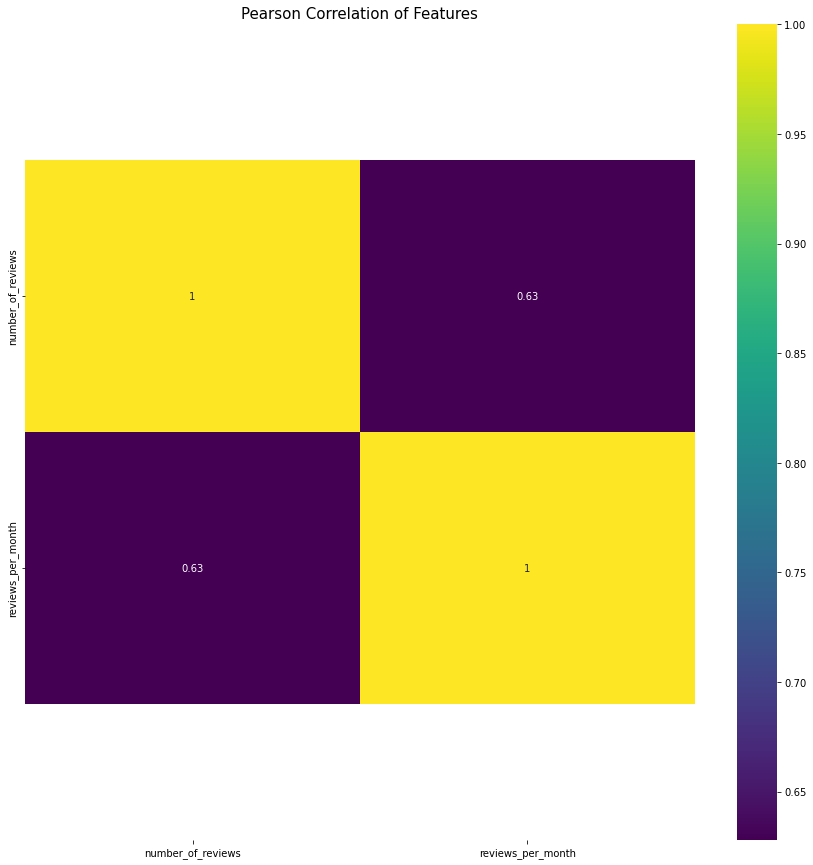

In [65]:
colormap = plt.cm.viridis
plt.figure(figsize=(15,15))
plt.title('Pearson Correlation of Features', size=15)
ax = sns.heatmap(listings_df_main[['number_of_reviews','reviews_per_month']].corr(), cmap=colormap, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [66]:
listings_df_main[listings_df_main['reviews_per_month'].isnull()]['number_of_reviews'].value_counts()

0    2758
Name: number_of_reviews, dtype: int64

Since last_review is a date type variable, we cannot simply replace it with a 0. However, all this variable shows is the last time since a listing has a review, and there hasnt been a reivew, there is not much that can be gained from this variable. This is because the information that last_review has been compressed into reviews_per_month. 

By extension, the same is true for reviews_per_month, where all nulls found in reviews_per_month have a non-null number_of_reviews. This means all the data that can be gained from reviews_per_month is already present in number_of_reviews, as can be seen from the correlation chart.

Thus, we will drop the variable

In [67]:
listings_df_main = listings_df_main.drop(columns=['last_review','reviews_per_month'])

### 2.1.3 Dealing with Outliers

In [68]:
listings_df_main.dtypes

neighbourhood_group               object
neighbourhood                     object
room_type                         object
price                              int64
minimum_nights                     int64
number_of_reviews                  int64
calculated_host_listings_count     int64
availability_365                   int64
dtype: object

Only age,length_of_service and avg_training_score will be considered for outlier handling</br>
no_of_trainings, previous_year_rating and all other int64 variables will be treated as categorical values

In [69]:
# get continuous variables
listings_df_outliers = listings_df_main[['price']].copy()
listings_df_outliers

,price
0,83
1,81
2,69
3,206
4,94
...,...
7902,100
7903,550
7904,58
7905,56


c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


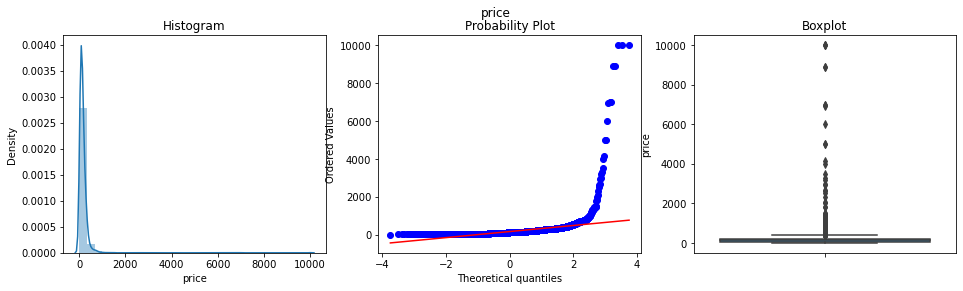

In [70]:
for cols in listings_df_outliers:
    diagnostic_plots(listings_df_outliers, cols)

It can be seen that there are a large number of outliers in the **Price** variable. This will result in the model trying to train for both low price and high priced listings. There is a fundamental difference in the listings between an affordable type listing vs a luxury listing. 

Thus, will we will focus on only one type of listing, a non-luxury type listing as it consists of a higher portion of the dataset.

In [71]:
# remove extremely high and low priced listings
upper_boundary = 160
lower_boundary = 30

print(upper_boundary)
print(lower_boundary)

print('Rows before removal: ',listings_df_main.shape[0])

listings_df_main = listings_df_main[listings_df_main['price'] <= upper_boundary]
listings_df_main = listings_df_main[listings_df_main['price'] >= lower_boundary]

print('Rows after removal: ',listings_df_main.shape[0])


160
30
Rows before removal:  7907
Rows after removal:  4981


c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


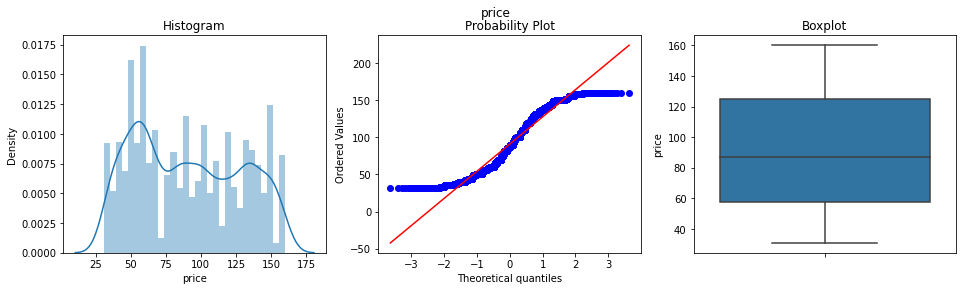

In [72]:
for col in listings_df_outliers:
    diagnostic_plots(listings_df_main, col)

In [73]:
listings_df_main.dtypes

neighbourhood_group               object
neighbourhood                     object
room_type                         object
price                              int64
minimum_nights                     int64
number_of_reviews                  int64
calculated_host_listings_count     int64
availability_365                   int64
dtype: object

### 2.1.4 Categorical Encoding

In [74]:
# get categorical variables that need encoding
listings_df_categorical = listings_df_main[['neighbourhood_group','room_type','neighbourhood']].copy()
listings_df_categorical.nunique()

neighbourhood_group     5
room_type               3
neighbourhood          40
dtype: int64

In [75]:
# ordinal encoding
# creates a map or integers ordered by the grouped mean relation to the target varaible 'price'
# this makes sure that as integer value increases, likelyhood of 'is_promoted' increases as well

# create a temporary dataframe to see change from encoding
listings_df_main_before = listings_df_main.copy()

for col in listings_df_categorical:
    # let's generate an ordered list with the labels of the columns
    ordered_labels = listings_df_main.groupby([col])['price'].mean().sort_values().index

    # next let's create a dictionary with the mappings of categories to numbers
    ordinal_mapping = {k: i for i, k in enumerate(ordered_labels, 0)}

    # replace the labels with the ordered numbers
    listings_df_main[col] = listings_df_main[col].map(ordinal_mapping)

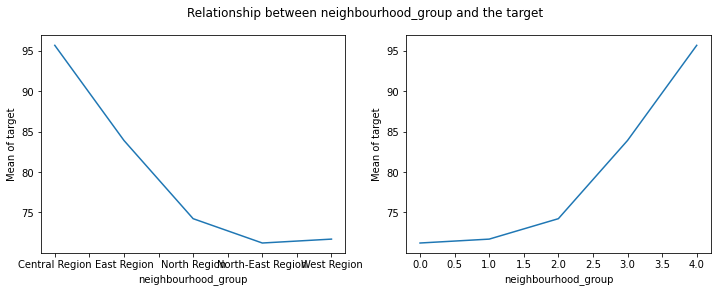

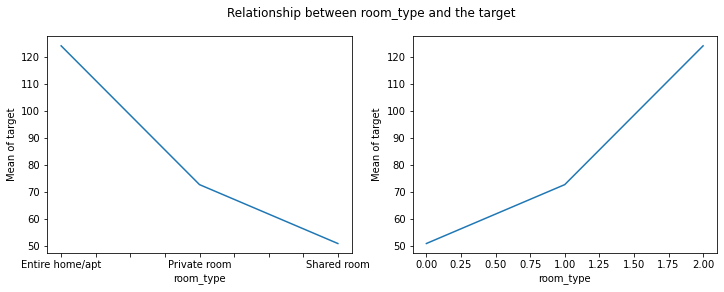

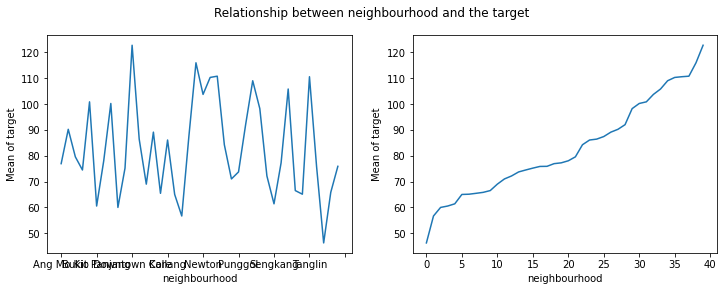

In [76]:
# let's find visualise the distributions
for col in listings_df_categorical:
    diagnostic_plots_monotonic_relation(listings_df_main_before, listings_df_main, col, 'price')

### 2.1.5 Scaling

In [77]:
# choose to scale target variable 'price'
scale_target = False

In [78]:
# set up the  MinMax Scaler
scaler = MinMaxScaler()

if scale_target:

    # fit the scaler to the df_main, it will learn the parameters
    scaler.fit(listings_df_main)

    # transform df_main
    listings_array_scaled = scaler.transform(listings_df_main)

    # let's transform the returned NumPy arrays to dataframes
    listings_df_main = pd.DataFrame(listings_array_scaled, columns=listings_df_main.columns)
    # listings_df_main = listings_df_scaled.join(listings_df_main['price'], left_index=True, right_index=True)
else:
    listings_df_main = listings_df_main.reindex(columns = [col for col in listings_df_main.columns if col != 'price'] + ['price'])
    listings_df_main

    # fit the scaler to the df_main, it will learn the parameters
    scaler.fit(listings_df_main.drop('price',axis=1))

    # transform df_main
    listings_array_scaled = scaler.transform(listings_df_main.drop('price',axis=1))

    # let's transform the returned NumPy arrays to dataframes
    listings_df_scaled = pd.DataFrame(listings_array_scaled, columns=listings_df_main.drop('price',axis=1).columns)
    # listings_df_main = listings_df_scaled.join(listings_df_main['price'], left_index=True, right_index=True)

    temp_df = listings_df_main['price'].reset_index()

    listings_df_main = listings_df_scaled.assign(price=temp_df['price'])

## 2.2 Build the Model(s)

### 2.2.1 Train Test Split 

In [79]:
# target variable not dropped in X_train, X_test for frequency encoding
listings_X_train, listings_X_test, listings_y_train, listings_y_test = train_test_split(listings_df_main.drop('price', axis=1),
                                                    listings_df_main['price'], 
                                                    test_size=0.3, 
                                                    random_state=20)

listings_X_train.shape, listings_X_test.shape, listings_y_train.shape, listings_y_test.shape

((3486, 7), (1495, 7), (3486,), (1495,))

In [80]:
listings_X_train

,neighbourhood_group,neighbourhood,room_type,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
4678,1.00,0.564103,0.5,0.000000,0.040248,0.047619,0.002740
3772,1.00,0.589744,0.5,0.028028,0.000000,0.000000,0.000000
1985,1.00,0.589744,0.5,0.027027,0.003096,0.300366,0.972603
3486,1.00,1.000000,1.0,0.029029,0.000000,1.000000,0.400000
4665,1.00,0.717949,0.5,0.000000,0.009288,0.000000,0.895890
...,...,...,...,...,...,...,...
1607,0.75,0.692308,1.0,0.089089,0.006192,0.003663,0.000000
3915,1.00,0.410256,1.0,0.002002,0.003096,0.000000,0.000000
1428,0.00,0.102564,0.5,0.179179,0.575851,0.003663,0.249315
4367,1.00,0.589744,0.5,0.001001,0.000000,0.000000,0.000000


In [81]:
listings_y_train

4678     69
3772     33
1985     35
3486    151
4665     60
       ... 
1607     69
3915    100
1428     40
4367     49
2522     87
Name: price, Length: 3486, dtype: int64

### 2.2.2 Linear Regression

In [82]:
# train the model using training set
listings_lin_reg = LinearRegression()
listings_lin_reg.fit(listings_X_train, listings_y_train)

LinearRegression()

### 2.2.3 Random Forest Regressor

In [83]:
listings_RFR = RandomForestRegressor(n_estimators=600, max_leaf_nodes=12, max_depth= 3,n_jobs=-1)
listings_RFR.fit(listings_X_train, listings_y_train)

RandomForestRegressor(max_depth=3, max_leaf_nodes=12, n_estimators=600,
                      n_jobs=-1)

### 2.2.4 XGBoostRegressor (ensemble Learning) 

In [84]:
# Build XGBoost Model 
listings_XGB = XGBRegressor()
listings_XGB.fit(listings_X_train,listings_y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

## 2.3 Evaluate and Improve the Model(s)

### 2.3.1 Linear Regression

#### Evaluate

In [85]:
# calculated the training accuracy
print(listings_lin_reg.score(listings_X_train, listings_y_train), '(Train Accuracy)')
# calculated the testing accuracy
print(listings_lin_reg.score(listings_X_test, listings_y_test), '(Test Accuracy)')

print('Train RMSE: \t',sqrt(mean_squared_error(listings_lin_reg.predict(listings_X_train), listings_y_train))) 
print('Test RMSE: \t',sqrt(mean_squared_error(listings_lin_reg.predict(listings_X_test), listings_y_test))) 

print('Train MAE: \t',mean_absolute_error(listings_lin_reg.predict(listings_X_train), listings_y_train))
print('Test MAE: \t',mean_absolute_error(listings_lin_reg.predict(listings_X_test), listings_y_test))

0.5020019293854785 (Train Accuracy)
0.5435811130261816 (Test Accuracy)
Train RMSE: 	 26.448366784122292
Test RMSE: 	 25.67548746306906
Train MAE: 	 20.65268666191082
Test MAE: 	 20.54715368808351


In [86]:
# Create another model hr_logReg_improv using statsmodel.api: the Logit method and fit function
listings_lin_reg_improv = sm.OLS(listings_y_train, listings_X_train).fit()
# Print out the Model Summary
listings_lin_reg_improv.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.926
Model:                            OLS   Adj. R-squared (uncentered):              0.926
Method:                 Least Squares   F-statistic:                              6197.
Date:                Sat, 11 Feb 2023   Prob (F-statistic):                        0.00
Time:                        18:38:48   Log-Likelihood:                         -16396.
No. Observations:                3486   AIC:                                  3.281e+04
Df Residuals:                    3479   BIC:                                  3.285e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
neighbourhood_group               -1.7816      1.933     -0.922      0.357      -5.572       2.009
neighbourhood                     44.2018      2.722     16.236      0.000      38.864      49.540
room_type                         90.0124      1.590     56.605      0.000      86.895      93.130
minimum_nights                   -78.2569     10.660     -7.341      0.000     -99.157     -57.357
number_of_reviews                 -5.7725      4.629     -1.247      0.213     -14.849       3.304
calculated_host_listings_count     2.2841      2.192      1.042      0.297      -2.013       6.581
availability_365                   9.4809      1.130      8.390      0.000       7.265      11.696
==============================================================================
Omnibus:                      362.513   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              521.463
Skew:                           0.798   Prob(JB):                    5.83e-114
Kurtosis:                       4.023   Cond. No.                         33.4
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Improvement

In [87]:
listings_lin_reg_improved = LinearRegression()
param_grid = {
    "fit_intercept": [True, False],
    "normalize" : [True, False]
    }

listings_gs_lin_reg =GridSearchCV(listings_lin_reg_improved, 
                                  param_grid = param_grid, 
                                  cv = 5, n_jobs = -1)

listings_gs_lin_reg = listings_gs_lin_reg.fit(listings_X_train, 
                                              listings_y_train)

print(listings_gs_lin_reg.best_params_)

{'fit_intercept': True, 'normalize': False}


#### Rebuilding Improved Linear Regression Model

In [88]:
# train the model using training set
listings_lin_reg_improved = LinearRegression(**listings_gs_lin_reg.best_params_)
listings_lin_reg_improved.fit(listings_X_train, listings_y_train)

LinearRegression()

#### Evaluating and Comparing Improved Model

In [89]:
# calculated the training accuracy
print("Train Accuracy (Improved): \t",listings_lin_reg_improved.score(listings_X_train, listings_y_train))
print("Train Accuracy (Unimproved): \t",listings_lin_reg.score(listings_X_train, listings_y_train))

print('Train RMSE (Improved): \t\t',sqrt(mean_squared_error(listings_lin_reg_improved.predict(listings_X_train), listings_y_train))) 
print('Train RMSE (Unimproved): \t',sqrt(mean_squared_error(listings_lin_reg.predict(listings_X_train), listings_y_train))) 

print('Train MAE (Improved): \t\t',mean_absolute_error(listings_lin_reg_improved.predict(listings_X_train), listings_y_train))
print('Train MAE (Unimproved): \t',mean_absolute_error(listings_lin_reg.predict(listings_X_train), listings_y_train))


Train Accuracy (Improved): 	 0.5020019293854785
Train Accuracy (Unimproved): 	 0.5020019293854785
Train RMSE (Improved): 		 26.448366784122292
Train RMSE (Unimproved): 	 26.448366784122292
Train MAE (Improved): 		 20.65268666191082
Train MAE (Unimproved): 	 20.65268666191082


In [90]:
# calculated the testing accuracy
print("Test Accuracy (Improved): \t",listings_lin_reg_improved.score(listings_X_test, listings_y_test))
print("Test Accuracy (Unimproved): \t",listings_lin_reg.score(listings_X_test, listings_y_test))

print('Test RMSE (Improved): \t\t',sqrt(mean_squared_error(listings_lin_reg_improved.predict(listings_X_test), listings_y_test))) 
print('Test RMSE (Unimproved): \t',sqrt(mean_squared_error(listings_lin_reg.predict(listings_X_test), listings_y_test))) 

print('Test MAE (Improved): \t\t',mean_absolute_error(listings_lin_reg_improved.predict(listings_X_test), listings_y_test)) 
print('Test MAE (Unimproved): \t',mean_absolute_error(listings_lin_reg.predict(listings_X_test), listings_y_test)) 

Test Accuracy (Improved): 	 0.5435811130261816
Test Accuracy (Unimproved): 	 0.5435811130261816
Test RMSE (Improved): 		 25.67548746306906
Test RMSE (Unimproved): 	 25.67548746306906
Test MAE (Improved): 		 20.54715368808351
Test MAE (Unimproved): 	 20.54715368808351


### 2.3.2 Random Forest Regressor

#### Evaluatation

In [91]:
# calculated the training accuracy
print(listings_RFR.score(listings_X_train, listings_y_train), '(Train Accuracy)')
# calculated the testing accuracy
print(listings_RFR.score(listings_X_test, listings_y_test), '(Test Accuracy)')

print('Train RMSE: \t',sqrt(mean_squared_error(listings_RFR.predict(listings_X_train), listings_y_train))) 
print('Test RMSE: \t',sqrt(mean_squared_error(listings_RFR.predict(listings_X_test), listings_y_test))) 

print('Train MAE: \t',mean_absolute_error(listings_RFR.predict(listings_X_train), listings_y_train))
print('Test MAE: \t',mean_absolute_error(listings_RFR.predict(listings_X_test), listings_y_test))

0.5258298831222841 (Train Accuracy)
0.5814895304466094 (Test Accuracy)
Train RMSE: 	 25.80786742942222
Test RMSE: 	 24.586123414928583
Train MAE: 	 20.14523922539737
Test MAE: 	 19.59960799269399


#### Improvement

In [92]:
# use gridsearch to get best params
listings_RFR_improved = RandomForestRegressor()

param_grid = {
'max_depth': [2, 3, 4],
'n_estimators': [50, 100, 200],
'min_samples_split': [2, 3, 4],
'min_samples_leaf': [1, 2, 3],
}

listings_gs_RFR = GridSearchCV(listings_RFR_improved, param_grid, cv=5, n_jobs=-1)

listings_gs_RFR.fit(listings_X_train, listings_y_train)

print(listings_gs_RFR.best_params_)

{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [93]:
keys = list(listings_gs_RFR.best_params_.keys())[1:]
values = list(listings_gs_RFR.best_params_.values())[1:]
best_params_no_max_depth = dict(zip(keys,values))
best_params_no_max_depth

{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

In [94]:
# Setting max_depth from 2 to 9 (8 different values)
# Training & evaluating the model 8 times with different max_depth value
# Store both simple split measures (train_mse & test_mse) and 
# cross validation measures (cross_val_train_mse & cross val_test_mse) into arrays

depth_range = range(2,10)

train_mse = []
test_mse = []
cross_val_train_mse =[]
cross_val_test_mse =[]

for d in depth_range:
    # Create Random Forest Model
    rf_reg = RandomForestRegressor(max_depth=d,**best_params_no_max_depth)
    rf_reg.fit(listings_X_train, listings_y_train) 
    train_mse.append(mean_squared_error(rf_reg.predict(listings_X_train), listings_y_train))
    test_mse.append(mean_squared_error(rf_reg.predict(listings_X_test), listings_y_test))

    results  = cross_validate(rf_reg,listings_df_main.drop('price', axis = 1),listings_df_main['price'], scoring='neg_mean_squared_error', cv=5, return_train_score = True)
    cross_val_train_mse.append(sum(-results['train_score'])/len(results['train_score']))
    cross_val_test_mse.append(sum(-results['test_score'])/len(results['test_score']))

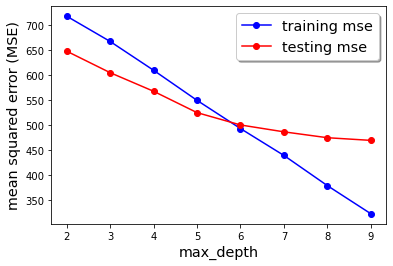

In [95]:
# Plot the simple split measures (train_mse & test_mse) 
plt.plot(depth_range, train_mse, 'bo-', label ='training mse')
plt.plot(depth_range, test_mse, 'ro-', label = 'testing mse')

plt.xlabel('max_depth', fontsize='x-large')
plt.ylabel('mean squared error (MSE)', fontsize='x-large')

plt.legend(loc='best', shadow=True, fontsize='x-large')
plt.show()

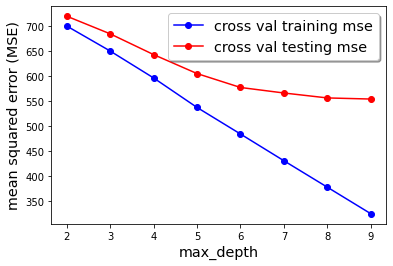

In [96]:
# Plot the cross validation measures (cross_val_train_mse & cross val_test_mse) 
plt.plot(depth_range, cross_val_train_mse, 'bo-', label ='cross val training mse')
plt.plot(depth_range, cross_val_test_mse, 'ro-', label = 'cross val testing mse')

plt.xlabel('max_depth', fontsize='x-large')
plt.ylabel('mean squared error (MSE)', fontsize='x-large')

plt.legend(loc='best', shadow=True, fontsize='x-large')
plt.show()

In [97]:
listings_RFR_improved = RandomForestRegressor(max_depth=7, **best_params_no_max_depth)
listings_RFR_improved.fit(listings_X_train, listings_y_train)

RandomForestRegressor(max_depth=7, n_estimators=50)

In [98]:
# calculated the training accuracy
print("Train Accuracy (Improved): \t",listings_RFR_improved.score(listings_X_train, listings_y_train))
print("Train Accuracy (Unimproved): \t",listings_RFR.score(listings_X_train, listings_y_train))

print('Train RMSE (Improved): \t\t',sqrt(mean_squared_error(listings_RFR_improved.predict(listings_X_train), listings_y_train))) 
print('Train RMSE (Unimproved): \t',sqrt(mean_squared_error(listings_RFR.predict(listings_X_train), listings_y_train))) 

print('Train MAE (Improved): \t\t',mean_absolute_error(listings_RFR_improved.predict(listings_X_train), listings_y_train)) 
print('Train MAE (Unimproved): \t',mean_absolute_error(listings_RFR.predict(listings_X_train), listings_y_train)) 

Train Accuracy (Improved): 	 0.6869594037625576
Train Accuracy (Unimproved): 	 0.5258298831222841
Train RMSE (Improved): 		 20.969368898510755
Train RMSE (Unimproved): 	 25.80786742942222
Train MAE (Improved): 		 15.67358239134621
Train MAE (Unimproved): 	 20.14523922539737


In [99]:
# calculated the testing accuracy
print("Test Accuracy (Improved): \t",listings_RFR_improved.score(listings_X_test, listings_y_test))
print("Test Accuracy (Unimproved): \t",listings_RFR.score(listings_X_test, listings_y_test))

print('Test RMSE (Improved): \t\t',sqrt(mean_squared_error(listings_RFR_improved.predict(listings_X_test), listings_y_test))) 
print('Test RMSE (Unimproved): \t',sqrt(mean_squared_error(listings_RFR.predict(listings_X_test), listings_y_test))) 

print('Test MAE (Improved): \t\t',mean_absolute_error(listings_RFR_improved.predict(listings_X_test), listings_y_test)) 
print('Test MAE (Unimproved): \t\t',mean_absolute_error(listings_RFR.predict(listings_X_test), listings_y_test)) 

Test Accuracy (Improved): 	 0.6641790937670852
Test Accuracy (Unimproved): 	 0.5814895304466094
Test RMSE (Improved): 		 22.023724134131207
Test RMSE (Unimproved): 	 24.58612341492858
Test MAE (Improved): 		 16.89124089431011
Test MAE (Unimproved): 		 19.59960799269399


### 2.3.3 XGBoostClassifier

#### Evaluation

In [100]:
# calculated the training accuracy
print(listings_XGB.score(listings_X_train, listings_y_train), '(Train Accuracy)')
# calculated the testing accuracy
print(listings_XGB.score(listings_X_test, listings_y_test), '(Test Accuracy)')

print('Train RMSE: \t',sqrt(mean_squared_error(listings_XGB.predict(listings_X_train), listings_y_train))) 
print('Test RMSE: \t',sqrt(mean_squared_error(listings_XGB.predict(listings_X_test), listings_y_test))) 

print('Train MAE: \t',mean_absolute_error(listings_XGB.predict(listings_X_train), listings_y_train))
print('Test MAE: \t',mean_absolute_error(listings_XGB.predict(listings_X_test), listings_y_test))

0.9012358961956787 (Train Accuracy)
0.6407556517288997 (Test Accuracy)
Train RMSE: 	 11.778353718293394
Test RMSE: 	 22.77885374171586
Train MAE: 	 7.962381114511057
Test MAE: 	 16.897717084852747


#### Improvement

In [101]:
# use gridsearch to get best params
listings_XGB_improved = XGBRegressor()

param_grid = {
'max_depth': [2, 3, 4],
'learning_rate': [0.1, 0.2, 0.3],
'n_estimators': [50, 100, 200],
}

listings_gs_XGB = GridSearchCV(listings_XGB_improved, param_grid, cv=5, n_jobs=-1)

listings_gs_XGB.fit(listings_X_train, listings_y_train)

print(listings_gs_XGB.best_params_)

{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}


In [102]:
keys = [list(listings_gs_XGB.best_params_.keys())[0],list(listings_gs_XGB.best_params_.keys())[-1]]
values = [list(listings_gs_XGB.best_params_.values())[0],list(listings_gs_XGB.best_params_.values())[-1]]
best_params_no_max_depth = dict(zip(keys,values))
best_params_no_max_depth

{'learning_rate': 0.2, 'n_estimators': 200}

In [103]:
# Setting max_depth from 2 to 9 (8 different values)
# Training & evaluating the model 8 times with different max_depth value
# Store both simple split measures (train_mse & test_mse) and 
# cross validation measures (cross_val_train_mse & cross val_test_mse) into arrays

depth_range = range(2,10)

train_mse = []
test_mse = []
cross_val_train_mse =[]
cross_val_test_mse =[]

for d in depth_range:
    # Create XGBRegressor
    xgb_reg = XGBRegressor(max_depth=d,**best_params_no_max_depth)
    xgb_reg.fit(listings_X_train, listings_y_train) 
    train_mse.append(mean_squared_error(xgb_reg.predict(listings_X_train), listings_y_train))
    test_mse.append(mean_squared_error(xgb_reg.predict(listings_X_test), listings_y_test))

    results  = cross_validate(xgb_reg,listings_df_main.drop('price', axis = 1),listings_df_main['price'], scoring='neg_mean_squared_error', cv=5, return_train_score = True)
    cross_val_train_mse.append(sum(-results['train_score'])/len(results['train_score']))
    cross_val_test_mse.append(sum(-results['test_score'])/len(results['test_score']))

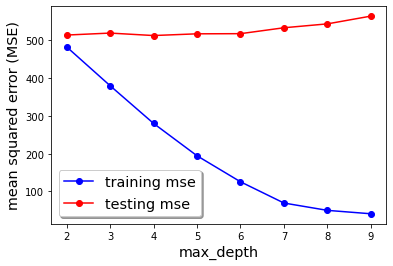

In [104]:
# Plot the simple split measures (train_mse & test_mse) 
plt.plot(depth_range, train_mse, 'bo-', label ='training mse')
plt.plot(depth_range, test_mse, 'ro-', label = 'testing mse')

plt.xlabel('max_depth', fontsize='x-large')
plt.ylabel('mean squared error (MSE)', fontsize='x-large')

plt.legend(loc='best', shadow=True, fontsize='x-large')
plt.show()

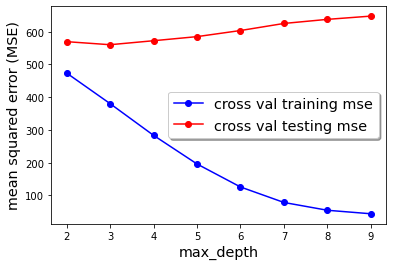

In [105]:
# Plot the cross validation measures (cross_val_train_mse & cross val_test_mse) 
plt.plot(depth_range, cross_val_train_mse, 'bo-', label ='cross val training mse')
plt.plot(depth_range, cross_val_test_mse, 'ro-', label = 'cross val testing mse')

plt.xlabel('max_depth', fontsize='x-large')
plt.ylabel('mean squared error (MSE)', fontsize='x-large')

plt.legend(loc='best', shadow=True, fontsize='x-large')
plt.show()

In [106]:
# Build XGBoost Model 
listings_XGB_improved = XGBRegressor(**listings_gs_XGB.best_params_)
listings_XGB_improved.fit(listings_X_train,listings_y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [107]:
# calculated the training accuracy
print("Train Accuracy (Improved): \t",listings_XGB_improved.score(listings_X_train, listings_y_train))
print("Train Accuracy (Unimproved): \t",listings_XGB.score(listings_X_train, listings_y_train))

print('Train RMSE (Improved): \t\t',sqrt(mean_squared_error(listings_XGB_improved.predict(listings_X_train), listings_y_train))) 
print('Train RMSE (Unimproved): \t',sqrt(mean_squared_error(listings_XGB.predict(listings_X_train), listings_y_train)))

print('Train MAE (Improved): \t\t',mean_absolute_error(listings_XGB_improved.predict(listings_X_train), listings_y_train)) 
print('Train MAE (Unimproved): \t',mean_absolute_error(listings_XGB.predict(listings_X_train), listings_y_train)) 

Train Accuracy (Improved): 	 0.7296369871119173
Train Accuracy (Unimproved): 	 0.9012358961956787
Train RMSE (Improved): 		 19.48761395203428
Train RMSE (Unimproved): 	 11.778353718293394
Train MAE (Improved): 		 14.494518519678953
Train MAE (Unimproved): 	 7.962381114511057


In [108]:
# calculated the testing accuracy
print("Test Accuracy (Improved): \t",listings_XGB_improved.score(listings_X_test, listings_y_test))
print("Test Accuracy (Unimproved): \t",listings_XGB.score(listings_X_test, listings_y_test))

print('Test RMSE (Improved): \t\t',sqrt(mean_squared_error(listings_XGB_improved.predict(listings_X_test), listings_y_test))) 
print('Test RMSE (Unimproved): \t',sqrt(mean_squared_error(listings_XGB.predict(listings_X_test), listings_y_test))) 

print('Test MAE (Improved): \t\t',mean_absolute_error(listings_XGB_improved.predict(listings_X_test), listings_y_test)) 
print('Test MAE (Unimproved): \t',mean_absolute_error(listings_XGB.predict(listings_X_test), listings_y_test)) 

Test Accuracy (Improved): 	 0.64075160741775
Test Accuracy (Unimproved): 	 0.6407556517288997
Test RMSE (Improved): 		 22.778981961565847
Test RMSE (Unimproved): 	 22.77885374171586
Test MAE (Improved): 		 17.32935583184794
Test MAE (Unimproved): 	 16.897717084852747


### 2.3.4 VotingRegressor 

#### Define Classifiers

In [109]:
# create list of Regressor 
classifier = [listings_lin_reg_improved,listings_RFR_improved,listings_XGB_improved]

#### Build and Fit VotingClassifier

In [110]:
# VotingRegressor  with hard voting technique
voting_clf = VotingRegressor(estimators=[('listings_lin_reg_improved', listings_lin_reg_improved), 
                                               ('listings_XGB_improved', listings_XGB_improved),
                                               ('listings_RFR_improved', listings_RFR_improved)],
                                   weights = [0.30,0.50,0.70])

# Let's train our voting Regressor. It's an estimator object so we call fit on our training data. It is used to train the Regressor
# before it can be used to make predictions. This will train all of the individual Regressors in the ensemble

voting_clf.fit(listings_X_train, listings_y_train)

VotingRegressor(estimators=[('listings_lin_reg_improved', LinearRegression()),
                            ('listings_XGB_improved',
                             XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          enable_categorical=False, gamma=0,
                                          gpu_id=-1, importance_type=None,
                                          interaction_constraints='',
                                          learning_rate=0.2, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=200, n_jobs=12,
                                 

In [111]:
for clf in (listings_lin_reg_improved,listings_RFR_improved,listings_XGB_improved, voting_clf):
    
    clf.fit(listings_X_train, listings_y_train)

    print(clf.__class__.__name__)
    print("Train Accuracy: \t",clf.score(listings_X_train, listings_y_train))
    print("Test Accuracy: \t\t",clf.score(listings_X_test, listings_y_test))
    
    print('Train RMSE: \t\t',sqrt(mean_squared_error(clf.predict(listings_X_train), listings_y_train))) 
    print('Test RMSE: \t\t',sqrt(mean_squared_error(clf.predict(listings_X_test), listings_y_test)),) 
    
    print('Train MAE: \t\t',mean_absolute_error(clf.predict(listings_X_train), listings_y_train))
    print('Test MAE: \t\t',mean_absolute_error(clf.predict(listings_X_test), listings_y_test))
    
    print('Train MSE: \t\t',(mean_squared_error(clf.predict(listings_X_train), listings_y_train))) 
    print('Test MSE: \t\t',(mean_squared_error(clf.predict(listings_X_test), listings_y_test)),'\n') 

LinearRegression
Train Accuracy: 	 0.5020019293854785
Test Accuracy: 		 0.5435811130261816
Train RMSE: 		 26.448366784122292
Test RMSE: 		 25.67548746306906
Train MAE: 		 20.65268666191082
Test MAE: 		 20.54715368808351
Train MSE: 		 699.5161055474634
Test MSE: 		 659.2306564662166 

RandomForestRegressor
Train Accuracy: 	 0.686719095913559
Test Accuracy: 		 0.6684227859239159
Train RMSE: 		 20.97741599733819
Test RMSE: 		 21.884127330770212
Train MAE: 		 15.720719279015073
Test MAE: 		 16.842087242234445
Train MSE: 		 440.05198192538023
Test MSE: 		 478.9150290293638 

XGBRegressor
Train Accuracy: 	 0.7296369871119173
Test Accuracy: 		 0.64075160741775
Train RMSE: 		 19.48761395203428
Test RMSE: 		 22.778981961565847
Train MAE: 		 14.494518519678953
Test MAE: 		 17.32935583184794
Train MSE: 		 379.7670975435211
Test MSE: 		 518.8820192053422 

VotingRegressor
Train Accuracy: 	 0.6907775392991514
Test Accuracy: 		 0.659541852046093
Train RMSE: 		 20.84109555740043
Test RMSE: 		 22.1752